### Operator Learning: Solving a ODE for different right hand sides

In this notebook, we present an introduction to the operator learning utilities of TorchPhysics. 
As an example, we start easy and try to learn the integral operator of the ODE:
\begin{align*}
    \partial_t u(t) &= f(t), \text{ in } (0, 1) \\
    u(0) &= 0
\end{align*}
for different functions $f$. 

We will cover different operator learning approaches as they are all unifited in TorchPhysics and can be easily swapped out. The following methods will be used in this introduction:

- Deep Operator Networks (DeepONet) [(paper)](https://arxiv.org/abs/2103.10974)
- Fourier Neural Operators (FNO) [(paper)](https://arxiv.org/abs/2010.08895)
- Model order reduction networks (PCANN) [(paper)](https://arxiv.org/abs/2005.03180)

We will not cover the underlying idea behind each approach, for this have a closer look at the papers. 
Instead the focus is on the implementation of operator learning in TorchPhysics. 

In [ ]:
import os, sys
sys.path.append(os.getcwd())

import torch 
import torchphysics as tp
import pytorch_lightning as pl

Given that most operator leaning approaches are data based by default (see [here](https://github.com/boschresearch/torchphysics/tree/main/examples/operator_learning/physics_informed) for physics informed methods), we requiere some data set that is used in training the network.

We provide a small method that creates some right-hand sides $f$ given by random oscillations and computes the 
corresponding solution with a Euler scheme.

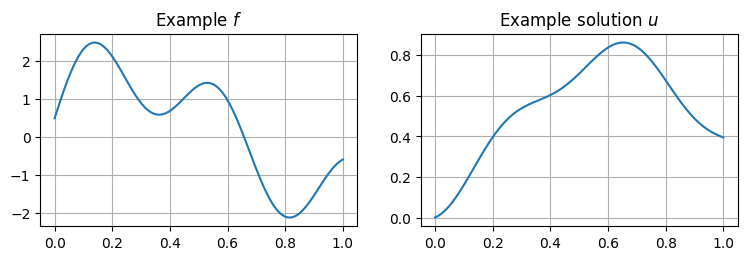

In [79]:
from datasets.generate_ode_data import generate_ode_data
import matplotlib.pyplot as plt

N_train = 10000 # number of training samples (u, f)
N_time = 100 # number of time steps
dt = 1.0/N_time # time step size

input_data, output_data = generate_ode_data(N_train, N_time, dt)

# Plot one example
f, axarr = plt.subplots(1,2, figsize=(9, 2.5))
axarr[0].plot(torch.linspace(0, 1, N_time), input_data[0])
axarr[0].title.set_text(r"Example $f$")
axarr[0].grid()
axarr[1].plot(torch.linspace(0, 1, N_time), output_data[0])
axarr[1].title.set_text(r"Example solution $u$")
axarr[1].grid()

In TorchPhysics we have to define the input and output space like in the PINN cases. Here we work with
functions that get the *time* as an input and output either $f$ or $u$.
Therefore, we now also define so called **FunctionSpaces** for internally defining what functions should get what variables
as input and what should the output.

In [80]:
T = tp.spaces.R1("t")
F = tp.spaces.R1("f")
U = tp.spaces.R1("u")

fn_space_F = tp.spaces.FunctionSpace(T, F)
fn_space_U = tp.spaces.FunctionSpace(T, U)

Next, we need to make the above data ready to be used for training. This follows a similar structure as for PINNs, where we need to define a domain and then a sampler.

Here, we are not working on domains but set of functions instead. So we create a so-called **FunctionSet**, which takes care of moving data to the GPU, the correct input and output shape and more. There are a great number of FunctionSets provided in TorchPhysics. Given that we are using a data-driven approach, we use the **DataFunctionSet** which takes a given data set and prepares it for the trainig process, similar to a Pytorch data set.

In [81]:
data_functionset_input = tp.domains.DataFunctionSet(fn_space_F, input_data)
data_functionset_output = tp.domains.DataFunctionSet(fn_space_U, output_data)

Next we create some **samplers**, that will sample some functions from the function sets. Again, as for PINNs different kind of sampelers are provided.

Here, we want to randomly sample 2500 functions from the whole data set and pass them on to the model and solver. Since this is a data driven approach both input and output data needs to be sampled. Clearly they should be sampled the same way so the input output ordering $(f, u)$ is not destroyed.

In [82]:
# We take random functions from our input:
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(2500, data_functionset_input)
# The output should be coupled to the correct input functions:
functionsampler_output = tp.samplers.FunctionSamplerCoupled(data_functionset_output, functionsampler_input)

Now, we need to decided what approach we want to use to solve the problem. As mentioned before different approaches can be used in TorchPhysics. The follwoing three cells each implement one approach. 

By default the FNOs are used, since the other cells are commented out. But we can easily switch to another approach by just commenting out the other approaches.

In [83]:
### DeepONet
# time_grid = torch.linspace(0, 1, N_time).reshape(-1, 1)
# trunk_net = tp.models.FCTrunkNet(T, default_trunk_input=time_grid, hidden=(30, 30))
# branch_net = tp.models.FCBranchNet(fn_space_F, hidden=(20, 20), grid=time_grid)
# model = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons=40)

In [ ]:
### FNO
hidden_channels = 8

model = tp.models.FNO(F, U, 
                      fourier_layers=3, 
                      hidden_channels=hidden_channels, 
                      fourier_modes=8, 
                      skip_connections=True, 
                      space_resolution=N_time # this smoothes the output, but removes the super resolution property of FNOs
                      )

In [ ]:
### Model order reduction network

### For this approach we also need to carry out PCA, which is preimplemented in the DataFunctionSet class 
# data_functionset_input.compute_pca(10) # <- the number of PC to use for the input
# data_functionset_output.compute_pca(10) # <- the number of PC to use for the output

# model = tp.models.PCANN_FC.from_fn_set(
#     data_functionset_input, data_functionset_output
# )

We now have a data set and our model at hand. What we are missing is a condition that tells us what should be learned.
Since in this case we are only fitting data, we use the **tp.conditions.OperatorCondition**.
By default this condition use the inputs from our input function sampler, passes them to the model and compare the model output with the data obtained from the output function sampler.

One can pass in customized residual functions if needed

In [86]:
data_condition = tp.conditions.OperatorCondition(module=model, 
                                                 input_function_sampler=functionsampler_input, 
                                                 output_function_sampler=functionsampler_output)

Now we can start to train the network:

In [87]:
lr_list = [0.01, 0.001, 0.0005]
step_list = [5000, 10000, 5000]

for i in range(len(lr_list)):
    optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=lr_list[i])
    solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

    trainer = pl.Trainer(devices=1, accelerator="gpu",
                        num_sanity_val_steps=0,
                        benchmark=True,
                        max_steps=step_list[i], 
                        logger=False, 
                        enable_checkpointing=False)

    trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 1.3 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 5000/5000 [00:23<00:00, 210.19it/s, train/loss=0.00161]

`Trainer.fit` stopped: `max_steps=5000` reached.


Epoch 0: 100%|██████████| 5000/5000 [00:23<00:00, 210.17it/s, train/loss=0.00161]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 1.3 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 10000/10000 [00:46<00:00, 214.11it/s, train/loss=0.000318]

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 0: 100%|██████████| 10000/10000 [00:46<00:00, 214.10it/s, train/loss=0.000318]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 1.3 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 5000/5000 [00:23<00:00, 213.62it/s, train/loss=0.000235]

`Trainer.fit` stopped: `max_steps=5000` reached.


Epoch 0: 100%|██████████| 5000/5000 [00:23<00:00, 213.60it/s, train/loss=0.000235]


For evaluation we create a new unseen data set and compare the model output with the expected solution.

In [90]:
N_test = 1000 # number of test samples (u, f)
input_test, output_test = generate_ode_data(N_test, N_time, dt)

if isinstance(model, tp.models.DeepONet):
    model_output = model(branch_inputs=tp.spaces.Points(input_test, F)).as_tensor
else:
    model_output = model(tp.spaces.Points(input_test, F)).as_tensor

rel_error = torch.max(torch.abs(model_output - output_test)) / torch.max(torch.abs(output_test))

print(f"Relative error: {rel_error*100} %")

Relative error: 0.5912859439849854 %


Example plot:


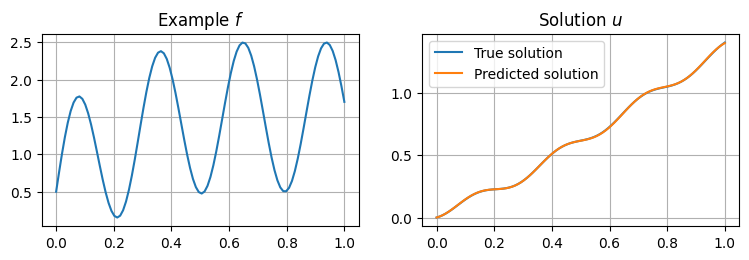

In [91]:
print("Example plot:")
plot_idx = 0
f, axarr = plt.subplots(1,2, figsize=(9, 2.5))
axarr[0].plot(torch.linspace(0, 1, N_time), input_test[plot_idx])
axarr[0].title.set_text(r"Example $f$")
axarr[0].grid()
axarr[1].plot(torch.linspace(0, 1, N_time), output_test[plot_idx])
axarr[1].plot(torch.linspace(0, 1, N_time), model_output[plot_idx].detach())
axarr[1].title.set_text(r"Solution $u$")
axarr[1].grid()
axarr[1].legend(["True solution", "Predicted solution"])